# Training a Food Model Classifier

## Downloading data
First, we download the Food-101 dataset that is open-sourced by ETH Zurich.

In [1]:
!pip install wget
import wget
# downloading dataset with wget
url = 'http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz'
wget.download(url, 'dataset.tar.gz')

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9681 sha256=b3bc36781297fa1152435fcc1e45c454fdf42c64e72b9402105c7cbbe4caacfd
  Stored in directory: /root/.cache/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget


'dataset.tar.gz'

## Unzipping dataset
We use tarfile to unzip the dataset

In [2]:
# unzipping dataset
import tarfile
fname = 'dataset.tar.gz'
tar = tarfile.open(fname, "r:gz")
tar.extractall()
tar.close()

## Visualize dataset
First, we inspect the dataset, and visualise the images

In [1]:
!tree food-101 -L 2

food-101
├── README.txt
├── images
│   ├── apple_pie
│   ├── baby_back_ribs
│   ├── baklava
│   ├── beef_carpaccio
│   ├── beef_tartare
│   ├── beet_salad
│   ├── beignets
│   ├── bibimbap
│   ├── bread_pudding
│   ├── breakfast_burrito
│   ├── bruschetta
│   ├── caesar_salad
│   ├── cannoli
│   ├── caprese_salad
│   ├── carrot_cake
│   ├── ceviche
│   ├── cheese_plate
│   ├── cheesecake
│   ├── chicken_curry
│   ├── chicken_quesadilla
│   ├── chicken_wings
│   ├── chocolate_cake
│   ├── chocolate_mousse
│   ├── churros
│   ├── clam_chowder
│   ├── club_sandwich
│   ├── crab_cakes
│   ├── creme_brulee
│   ├── croque_madame
│   ├── cup_cakes
│   ├── deviled_eggs
│   ├── donuts
│   ├── dumplings
│   ├── edamame
│   ├── eggs_benedict
│   ├── escargots
│   ├── falafel
│   ├── filet_mignon
│   ├── fish_and_chips
│   ├── foie_gras
│   ├── french_fries
│   ├── french_onion_soup
│   ├── french_toast
│   ├── fried_calamari
│   ├── fried_rice
│   ├── frozen_yogurt
│   ├── garlic_bread
│   ├── gn

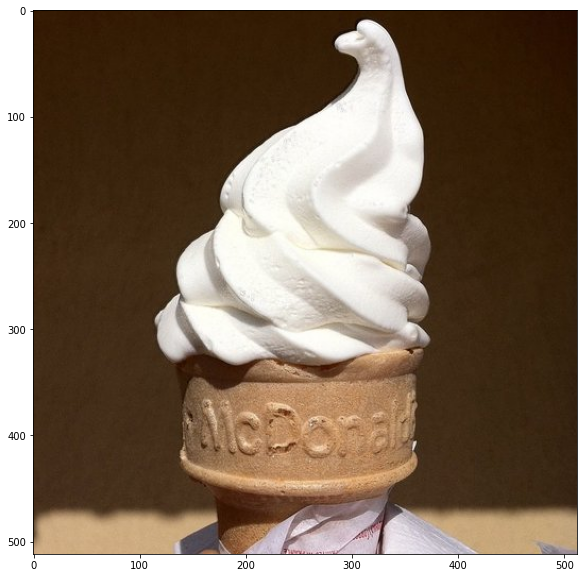

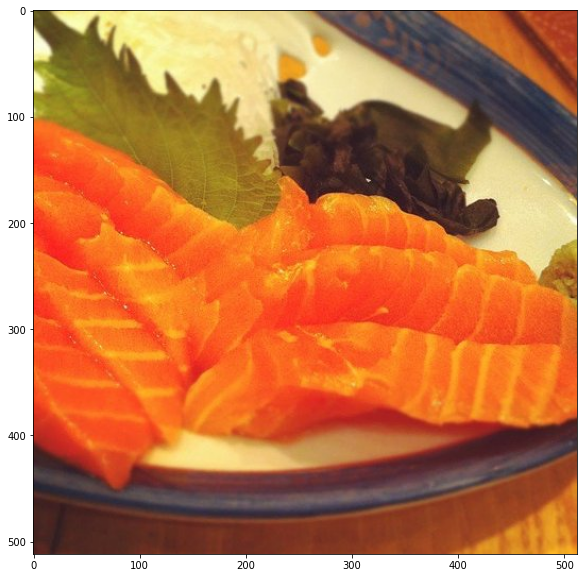

In [5]:
import mmcv
import matplotlib.pyplot as plt
import os 
%matplotlib inline 

cur_dir = os.getcwd()
image_dir = os.path.join(cur_dir,'food-101','images')
icecream_dir = os.path.join(image_dir,'ice_cream')
sashimi_dir = os.path.join(image_dir,'sashimi')
for food_type in [icecream_dir,sashimi_dir]:
    filename = os.listdir(food_type)[0]
    img = mmcv.imread(os.path.join(food_type,filename))
    plt.figure(figsize=(15, 10))
    plt.imshow(mmcv.bgr2rgb(img))
    plt.show()

## Data Format
We want to use the [mmclassification](https://github.com/open-mmlab/mmclassification) library provided by [OpenMMLab](https://github.com/open-mmlab).

Based on the [docs](https://mmclassification.readthedocs.io/en/latest/index.html), we need to convert the dataset to the Imagenet classification format. The Imagenet classification format has training data in:
```
train
    label_1/
        XXXX.jpg
        ...
    label_2/
        YYYY.jpg
        ...
    ...
```
And validation data in the form of:
```
val
    XXXX.jpg
    YYYY.jpg
```
Along with a text file, e.g. `val_imagenet.txt` in the form of:
```
XXXX.jpg 0
YYYY.jpg 1
```
With the second value as the class index (which should match the alphabetically sorted `label_1`,`label_2`,...etc. folder names of the train dataset.

The Food101 dataset already has images in the train format for Imagenet. We need to extract all test/val datasets from the Food101 image dataset, put them in a `val` folder, and create a text file with the path to the image and the class index 

In [11]:
CLASSES = {}
classes_file = os.path.join(cur_dir,'food-101','meta','classes.txt')
with open(classes_file) as f:
    for count,x in enumerate(f.readlines()):
        CLASSES[x[:-1]] = count

In [21]:
import shutil
test_labels = os.path.join(cur_dir,'food-101','meta','test.txt')
test_dir = os.path.join(cur_dir,'food-101','test')
os.makedirs(test_dir,exist_ok=True)

test_samples = []
new_test_labels = os.path.join(cur_dir,'food-101','meta','test_imagenet.txt')
with open(test_labels) as f:
    for x in f.readlines():
        image_location = os.path.join(image_dir,x[:-1]+'.jpg')
        new_location = os.path.join(test_dir,x[:-1]+'.jpg')
        os.makedirs(os.path.dirname(new_location),exist_ok=True)
        shutil.move(
            image_location,
            new_location
        )
        test_samples.append(
            new_location+' '+str(CLASSES[x.split('/')[0]])
        )

### Review size of datasets
We use the following commands to check the size of the validation and training datasets

In [22]:
!find food-101/test -type f | wc -l

25250


In [23]:
!find food-101/images -type f | wc -l

75750


In [28]:
#Write the collected metadata of the validation dataset 
#into the format required by mmclassification
with open(new_test_labels,'w') as f:
    f.write('\n'.join(test_samples) + '\n')

In [29]:
#Double-check that the text file is as expected
!head -n 10 food-101/meta/test_imagenet.txt

/home/mmclassify-tutorial/food-101/test/apple_pie/1011328.jpg 0
/home/mmclassify-tutorial/food-101/test/apple_pie/101251.jpg 0
/home/mmclassify-tutorial/food-101/test/apple_pie/1034399.jpg 0
/home/mmclassify-tutorial/food-101/test/apple_pie/103801.jpg 0
/home/mmclassify-tutorial/food-101/test/apple_pie/1038694.jpg 0
/home/mmclassify-tutorial/food-101/test/apple_pie/1047447.jpg 0
/home/mmclassify-tutorial/food-101/test/apple_pie/1068632.jpg 0
/home/mmclassify-tutorial/food-101/test/apple_pie/110043.jpg 0
/home/mmclassify-tutorial/food-101/test/apple_pie/1106961.jpg 0
/home/mmclassify-tutorial/food-101/test/apple_pie/1113017.jpg 0


## Training Configuration
This training configuration is edited based on the `train.py` file provided by mmclassification (see [here](https://github.com/open-mmlab/mmclassification/blob/master/tools/train.py)).

In [1]:
from mmcv import Config, DictAction
from mmcls.apis import set_random_seed, train_model
from mmcls.datasets import build_dataset
from mmcls.models import build_classifier
from mmcls.utils import collect_env, get_root_logger

### Model choice
This is a complex topic, so we will not cover much here beyond what you need to know to train a model.

#### Model Zoo
Most libraries would have a model zoo, which is a collection of implemented architectures/layers/models. The model zoo often comes with pretrained weights on some established benchmark dataset. For our problem, we are dealing with image classification - the benchmark dataset is usually [ImageNet](https://en.wikipedia.org/wiki/ImageNet). For mmclassification, the model zoo can be found [here](https://github.com/open-mmlab/mmclassification/blob/master/docs/model_zoo.md).

Generally, model zoos show important characteristics that define "performance" or "complexity" of a model. Params (M) indicates the number of learnable parameters (in millions). FLOPs (G) indicates the number of floating point operations usually for a single forward pass for a single image. Top-N (%) indicates the accuracy of classification of the model over the test dataset, taking the top N classifications. This means if given a sample image of ice cream, the model guesses (1) apple pie, (2) sashimi, (3) ice cream. The Top-1 accuracy is 0%, but the Top-3 accuracy is 100%.

In [23]:
cfg = Config.fromfile(
    'mmclassification/configs/shufflenet_v2/shufflenet_v2_1x_b64x16_linearlr_bn_nowd_imagenet.py')

Here, we utilise the dataset that we just built, replacing the default ImageNet values

In [34]:
new_test_labels = os.path.join(cur_dir,'food-101','meta','test_imagenet.txt')
cfg.data.train.data_prefix = image_dir
cfg.data.val.data_prefix = '/'
cfg.data.val.ann_file = new_test_labels
cfg.data.test.data_prefix = '/'
cfg.data.test.ann_file = new_test_labels
cfg.data.samples_per_gpu = 384

In [35]:
cfg.model

{'type': 'ImageClassifier',
 'backbone': {'type': 'ShuffleNetV2', 'widen_factor': 1.0},
 'neck': {'type': 'GlobalAveragePooling'},
 'head': {'type': 'LinearClsHead',
  'num_classes': 101,
  'in_channels': 1024,
  'loss': {'type': 'CrossEntropyLoss', 'loss_weight': 1.0},
  'topk': (1, 5)}}

We see that we need to replace the num_classes to 101, instead of 1000 (number of classes for ImageNet)

In [36]:
cfg.model.head.num_classes = 101

In [37]:
import os.path as osp
import time
cfg.work_dir = 'food-101-workdir'
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
cfg.dump(osp.join(cfg.work_dir, 'shufflenet_food101.config'))
timestamp = time.strftime('%Y%m%d_%H%M%S', time.localtime())
log_file = osp.join(cfg.work_dir, f'{timestamp}.log')
logger = get_root_logger(log_file=log_file, log_level=cfg.log_level)

We start training the model from the model pretrained on ImageNet, rather than starting from scratch.

In [15]:
!wget https://download.openmmlab.com/mmclassification/v0/shufflenet_v2/shufflenet_v2_batch1024_imagenet_20200812-5bf4721e.pth

--2021-06-20 08:08:34--  https://download.openmmlab.com/mmclassification/v0/shufflenet_v2/shufflenet_v2_batch1024_imagenet_20200812-5bf4721e.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.74.197.85
Connecting to download.openmmlab.com (download.openmmlab.com)|47.74.197.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9238066 (8.8M) [application/octet-stream]
Saving to: ‘shufflenet_v2_batch1024_imagenet_20200812-5bf4721e.pth’

shufflenet_v2_batch 100%[===================>]   8.81M  10.4MB/s    in 0.9s    

2021-06-20 08:08:36 (10.4 MB/s) - ‘shufflenet_v2_batch1024_imagenet_20200812-5bf4721e.pth’ saved [9238066/9238066]



In [38]:
cfg.resume_from = os.path.join(
    os.getcwd(),
    'shufflenet_v2_batch1024_imagenet_20200812-5bf4721e.pth'
)

In [39]:
meta = dict()
# log env info
env_info_dict = collect_env()
env_info = '\n'.join([(f'{k}: {v}') for k, v in env_info_dict.items()])
dash_line = '-' * 60 + '\n'
logger.info('Environment info:\n' + dash_line + env_info + '\n' +
            dash_line)
meta['env_info'] = env_info

2021-06-20 08:11:24,698 - mmcls - INFO - Environment info:
------------------------------------------------------------
sys.platform: linux
Python: 3.8.8 (default, Feb 24 2021, 21:46:12) [GCC 7.3.0]
CUDA available: True
GPU 0: GeForce RTX 3090
GPU 1: TITAN RTX
CUDA_HOME: /usr/local/cuda
NVCC: Build cuda_11.1.TC455_06.29190527_0
GCC: gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
PyTorch: 1.8.0
PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.2 Product Build 20200624 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v1.7.0 (Git Hash 7aed236906b1f7a05c0917e5257a1af05e9ff683)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.1
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_61,code=sm_61;-gencode;arch=compute_70,code=sm_70;-gencode;a

In [40]:
logger.info(f'Config:\n{cfg.pretty_text}')
model = build_classifier(cfg.model)
model.init_weights()

2021-06-20 08:11:25,483 - mmcls - INFO - Config:
model = dict(
    type='ImageClassifier',
    backbone=dict(type='ShuffleNetV2', widen_factor=1.0),
    neck=dict(type='GlobalAveragePooling'),
    head=dict(
        type='LinearClsHead',
        num_classes=101,
        in_channels=1024,
        loss=dict(type='CrossEntropyLoss', loss_weight=1.0),
        topk=(1, 5)))
dataset_type = 'ImageNet'
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='RandomResizedCrop', size=224, backend='pillow'),
    dict(type='RandomFlip', flip_prob=0.5, direction='horizontal'),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True),
    dict(type='ImageToTensor', keys=['img']),
    dict(type='ToTensor', keys=['gt_label']),
    dict(type='Collect', keys=['img', 'gt_label'])
]
test_pipeline = [
    dict(type='Loa

In [41]:
import copy
datasets = [build_dataset(cfg.data.train)]
val_dataset = copy.deepcopy(cfg.data.val)
val_dataset.pipeline = cfg.data.train.pipeline
datasets.append(build_dataset(val_dataset))

In [42]:
cfg.gpu_ids=range(1)
cfg.seed = None
meta['seed'] = None

In [48]:
cfg.lr_config = dict(policy='step', gamma=0.98, step=1)
cfg.runner = dict(type='EpochBasedRunner', max_epochs=310)

In [49]:
cfg.workflow = [('train', 1),('val',1)]

In [ ]:
train_model(
        model,
        datasets,
        cfg,
        distributed=False,
        validate=True,
        timestamp=timestamp,
        device='cuda',
        meta=meta)

2021-06-20 09:09:17,404 - mmcls - INFO - load checkpoint from food-101-workdir/latest.pth
2021-06-20 09:09:17,405 - mmcls - INFO - Use load_from_local loader
2021-06-20 09:09:17,495 - mmcls - INFO - resumed epoch 300, iter 375600
2021-06-20 09:09:17,497 - mmcls - INFO - Start running, host: root@78c1fc453d4b, work_dir: /home/mmclassify-tutorial/food-101-workdir
2021-06-20 09:09:17,497 - mmcls - INFO - workflow: [('train', 1), ('val', 1)], max: 310 epochs
2021-06-20 09:11:02,135 - mmcls - INFO - Epoch [301][100/198]	lr: 1.166e-03, eta: -4 days, 4:42:52, time: 1.046, data_time: 0.932, memory: 7156, loss: 1.8898


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 25250/25250, 407.4 task/s, elapsed: 62s, ETA:     0s

2021-06-20 09:13:44,386 - mmcls - INFO - Saving checkpoint at 301 epochs
2021-06-20 09:13:44,440 - mmcls - INFO - Epoch(val) [301][66]	accuracy_top-1: 65.2396, accuracy_top-5: 87.1802
2021-06-20 09:14:54,158 - mmcls - INFO - Epoch(val) [301][66]	loss: 1.7283
2021-06-20 09:16:38,406 - mmcls - INFO - Epoch [302][100/198]	lr: 1.143e-03, eta: -3 days, 10:49:00, time: 1.041, data_time: 0.932, memory: 7156, loss: 1.8407


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 25250/25250, 409.7 task/s, elapsed: 62s, ETA:     0s

2021-06-20 09:19:18,719 - mmcls - INFO - Saving checkpoint at 302 epochs
2021-06-20 09:19:18,773 - mmcls - INFO - Epoch(val) [302][66]	accuracy_top-1: 66.3406, accuracy_top-5: 87.7743
2021-06-20 09:20:28,391 - mmcls - INFO - Epoch(val) [302][66]	loss: 1.6774
2021-06-20 09:22:13,199 - mmcls - INFO - Epoch [303][100/198]	lr: 1.120e-03, eta: -3 days, 16:45:47, time: 1.047, data_time: 0.921, memory: 7156, loss: 1.7795


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 25250/25250, 410.2 task/s, elapsed: 62s, ETA:     0s

2021-06-20 09:24:54,314 - mmcls - INFO - Saving checkpoint at 303 epochs
2021-06-20 09:24:54,372 - mmcls - INFO - Epoch(val) [303][66]	accuracy_top-1: 67.0099, accuracy_top-5: 88.3248
2021-06-20 09:26:04,432 - mmcls - INFO - Epoch(val) [303][66]	loss: 1.6265
2021-06-20 09:27:49,232 - mmcls - INFO - Epoch [304][100/198]	lr: 1.098e-03, eta: -3 days, 19:18:05, time: 1.047, data_time: 0.922, memory: 7156, loss: 1.7437


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 25250/25250, 409.6 task/s, elapsed: 62s, ETA:     0s

2021-06-20 09:30:30,479 - mmcls - INFO - Saving checkpoint at 304 epochs
2021-06-20 09:30:30,535 - mmcls - INFO - Epoch(val) [304][66]	accuracy_top-1: 67.7386, accuracy_top-5: 88.7129
2021-06-20 09:31:40,441 - mmcls - INFO - Epoch(val) [304][66]	loss: 1.6114
2021-06-20 09:33:24,939 - mmcls - INFO - Epoch [305][100/198]	lr: 1.076e-03, eta: -3 days, 20:43:46, time: 1.044, data_time: 0.924, memory: 7156, loss: 1.6860


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 25250/25250, 413.9 task/s, elapsed: 61s, ETA:     0s

2021-06-20 09:36:05,756 - mmcls - INFO - Saving checkpoint at 305 epochs
2021-06-20 09:36:05,811 - mmcls - INFO - Epoch(val) [305][66]	accuracy_top-1: 68.4040, accuracy_top-5: 88.9901
2021-06-20 09:37:15,470 - mmcls - INFO - Epoch(val) [305][66]	loss: 1.5714
2021-06-20 09:39:00,210 - mmcls - INFO - Epoch [306][100/198]	lr: 1.054e-03, eta: -3 days, 21:36:32, time: 1.046, data_time: 0.936, memory: 7156, loss: 1.6620


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 25250/25250, 412.4 task/s, elapsed: 61s, ETA:     0s

2021-06-20 09:41:40,146 - mmcls - INFO - Saving checkpoint at 306 epochs
2021-06-20 09:41:40,201 - mmcls - INFO - Epoch(val) [306][66]	accuracy_top-1: 68.9426, accuracy_top-5: 89.3505
